# Linear Regression Baseline - LB 1.092
In this notebook, we provide a linear regression baseline for Kaggle's GoDaddy Microbusiness Density Forecast Competition. In this competition we are given 3135 timeseries of length 39. This is 39 months of microbusiness density from August 2019 thru October 2022 inclusive. We must predict microbusiness density for the next 8 months November 2022 thru June 2023 inclusive. Each time series is a different county in the United States. Therefore we will make `25080 = 3135 * 8` predictions.

The simplest baseline provided by Tawara is to just predict the last known microbusiness value for each county [here][1]. This achieves LB 1.093. Maybe we can improve this baseline by applying linear regression to the time series that appear to follow a linear trend. There are 486 counties exhibiting a linear trend (with train error less than 10% train range). Below we plot 8 random (out of 3135) time series, and then we plot 8 time series that have a linear trend.

### Updates
In version 1, we assumed linear trend if train error was less than 10% of train range (and achieved LB 1.113). In notebook version 2, 3, 4 we set the threshold to 5%, 3.8%, and 3% respectively (and achieved LB 1.094, 1.093, 1.093). Note in version 4, the threshold only modified one prediction from the "last value" baseline. (Whereas versions 1,2,3 modified 486, 22, 2 respectively).

Ha ha, version 4 beats the "last value" baseline but this isn't a big accomplishment because we only changed one county's predictions. It may have just been lucky actually. In version 5 and 8, we set threshold for linear trend back to 10% (same as version 1). Perhaps there is a way to use linear regression in a more significant way and beat the "last value" baseline more significantly. Stay tuned for future notebook versions!

New update: version 9 beats "last value" baseline by `+0.001` woohoo!. We limited our linear model predictions to counties with population 25,000 or above. This worked well because a trend involving more population should be more likely to continue. The importance of population is explained [here][2]. For local CV, using error threshold 12.8% and population threshold 9,000 is best. Let's make some more LB submissions to see if the same hyperparameters are optimal for LB...

### Version Notes
* version 4 - uses linear regression for 1 prediction (where train error < 3% train range). Achieves LB 1.093 beating the "last value" baseline
* version 5 - uses linear regression for 486 predictions (where train error < 10% train range). Achieves LB 1.113
* version 6 - ensembles 486 linear regression predictions with "last value" at weights 5% and 95%. Achieves LB 1.094
* version 7 - uses 5% threshold (which modifies 22 counties) and scale global prediction total to match global prediction total of "last value" baseline. Achieves LB 1.109
* version 8 - same as version 5. Uses linear regression for 486 predictions (where train error < 10% train range). Achieves LB 1.113
* version 9 - uses 10% threshold and county needs more than 25,000 active. Achieves LB 1.092 (and CV 1.098) and beats "last value" baseline. Woohoo!
* version 10 - uses 10% threshold and county needs more than 9,000 active (CV 1.096). Achieves LB 1.093
* version 11 - same as version 9 but makes code to detect linear trend more readable.

[1]: https://www.kaggle.com/code/ttahara/gd-mdf-last-target-baseline
[2]: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/373099

# Load Libraries, Train, Test

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('../train.csv')
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [3]:
print( train.shape )
train.head()

(122265, 7)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
test = pd.read_csv('../test.csv')
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

In [5]:
print(test.shape)
test.head()

(25080, 3)


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


# Data EDA
Below we observe that both train and test data have 3135 unique counties (i.e. `cfips`). In the train data, each county has 39 months of data. And in the test data, each county expects us to predict 8 months. By displaying the `min` and `max` dates, we discover that train data ranges from August 2019 thru October 2020 inclusive. And test data ranges from November 2022 thru June 2023 inclusive. We also plot 8 random time series below. We observe that in general, the time series do not have a consistent linear trend.

In [6]:
train.cfips.value_counts()

cfips
1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: count, Length: 3135, dtype: int64

In [7]:
test.cfips.value_counts()

cfips
1001     8
39133    8
39089    8
39091    8
39093    8
        ..
21113    8
21115    8
21117    8
21119    8
56045    8
Name: count, Length: 3135, dtype: int64

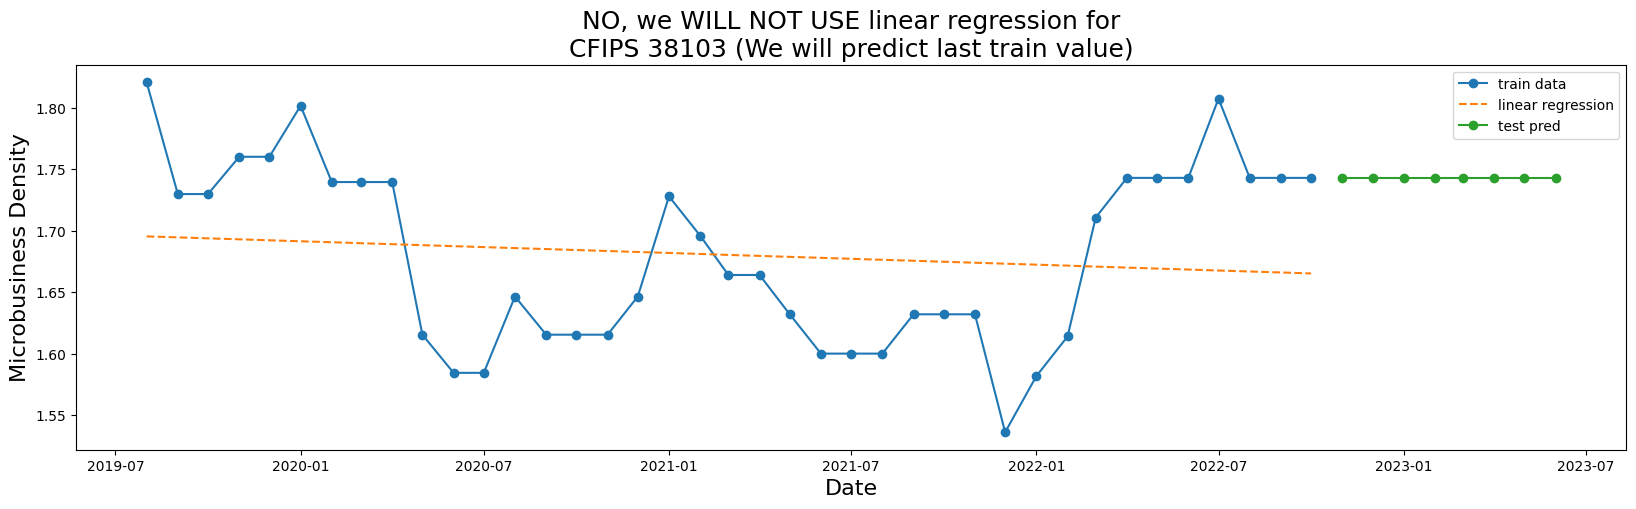

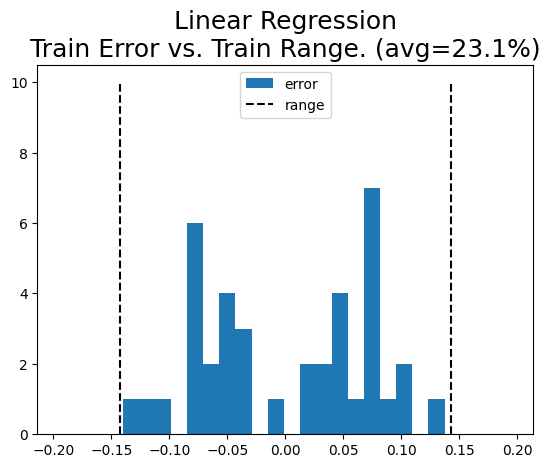

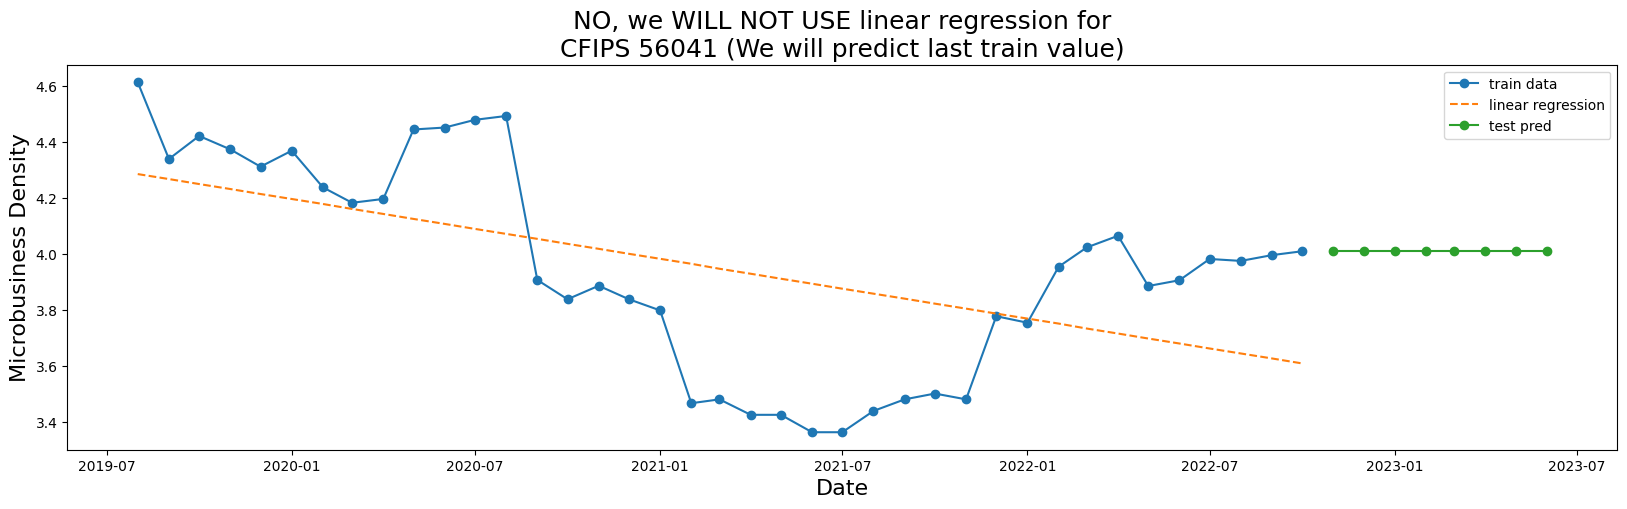

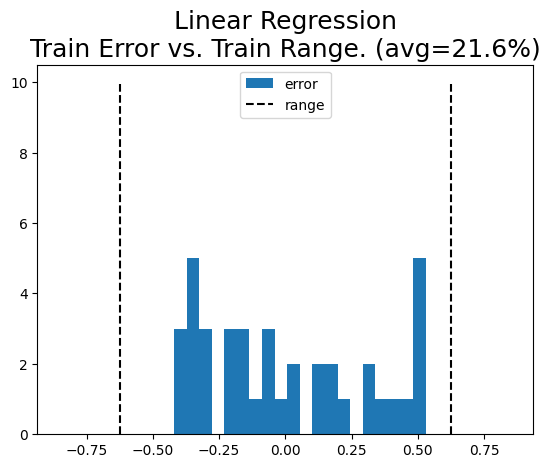

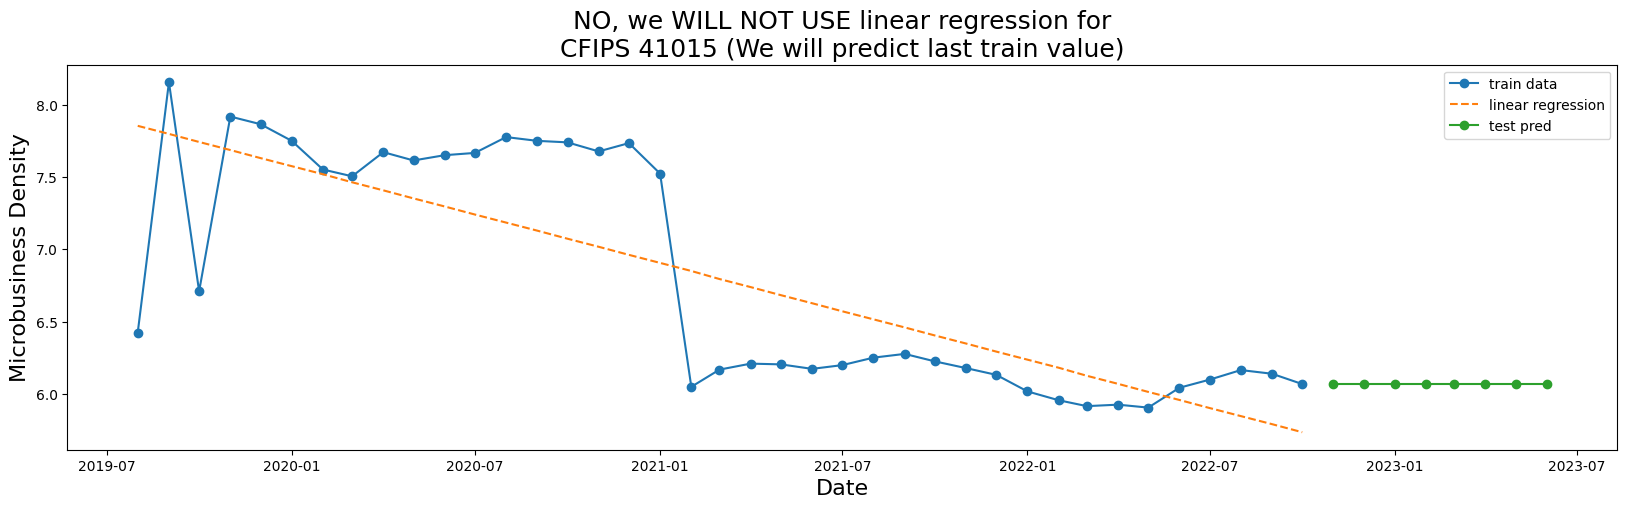

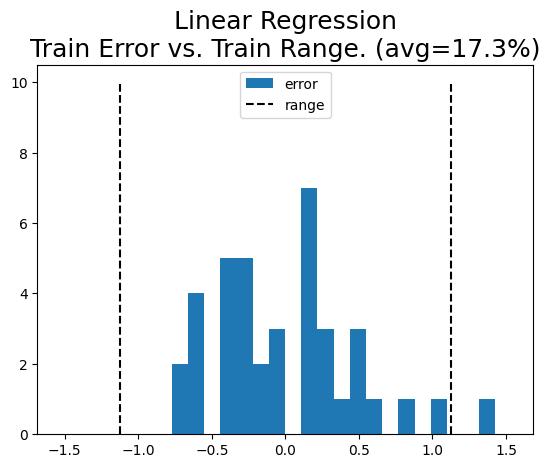

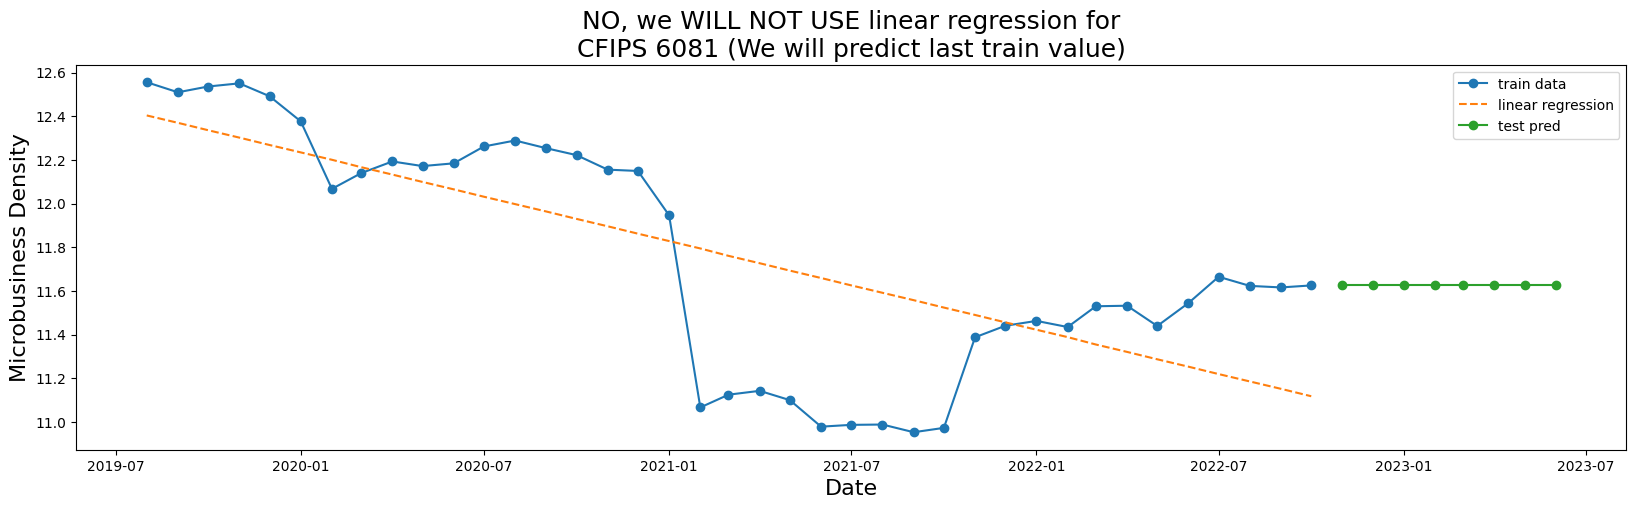

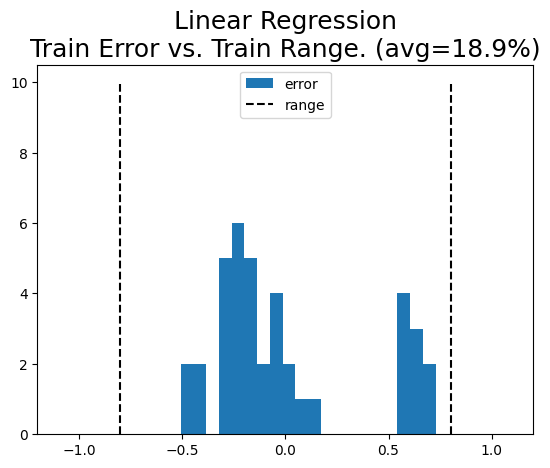

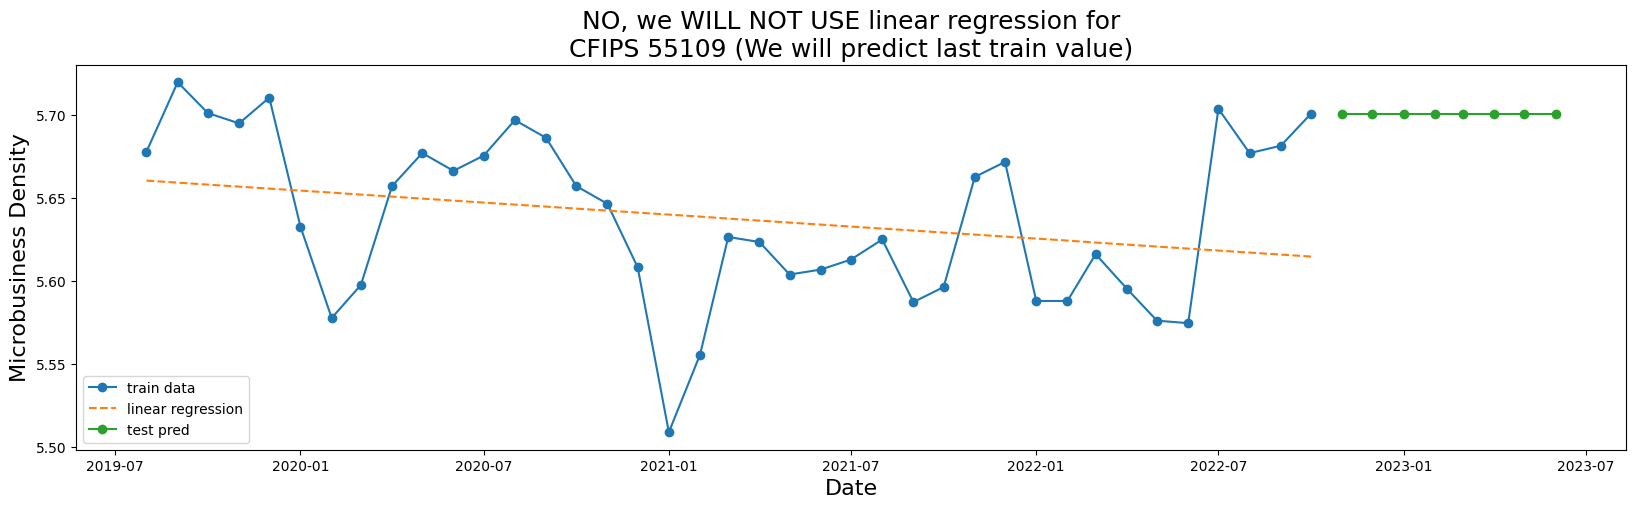

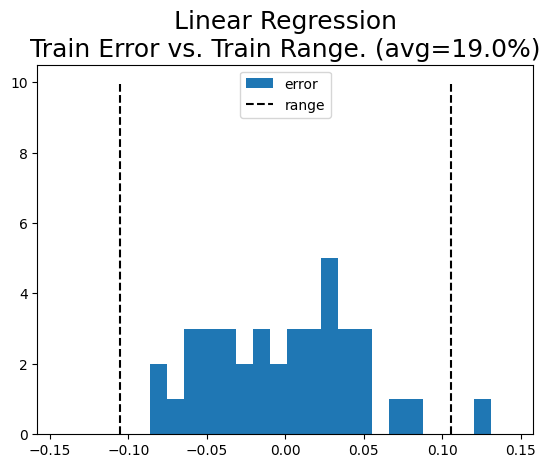

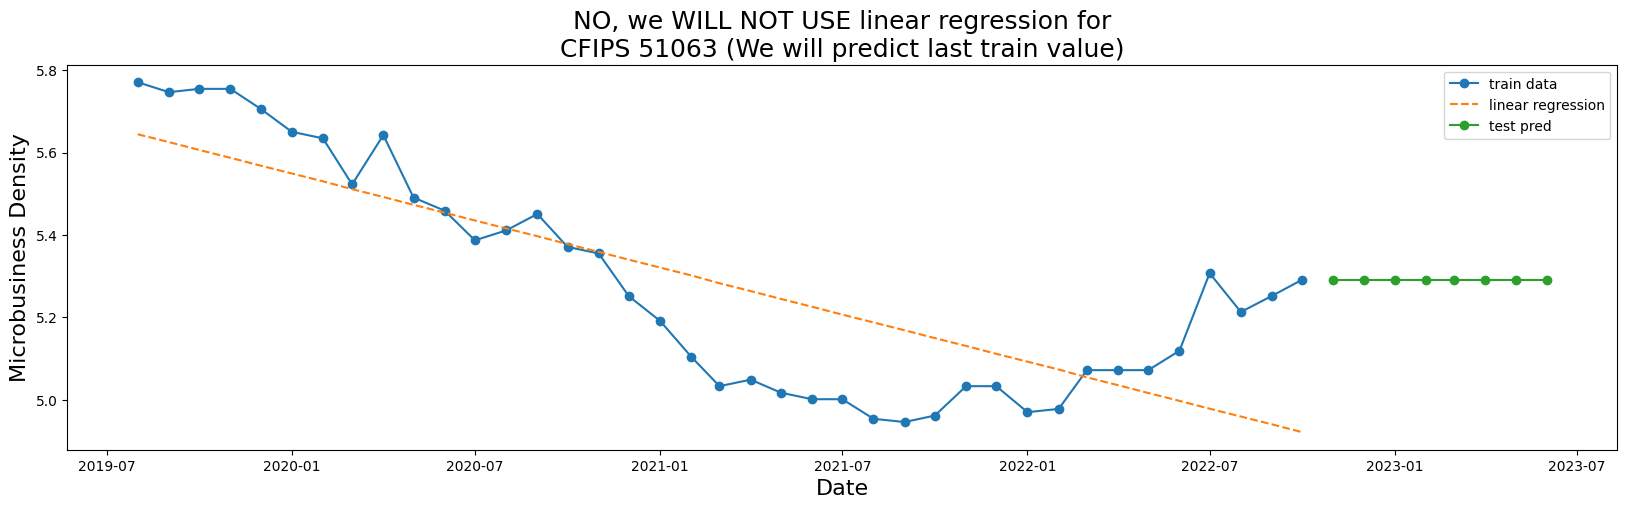

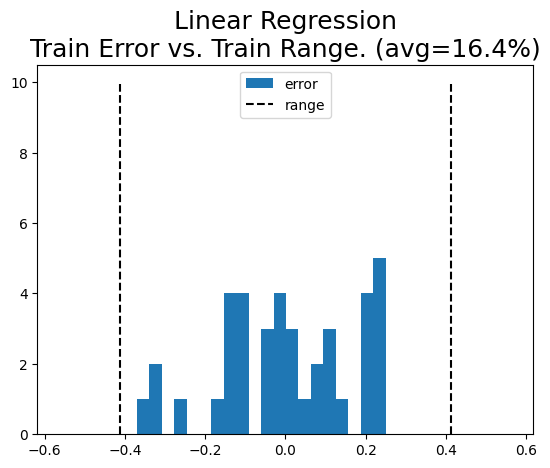

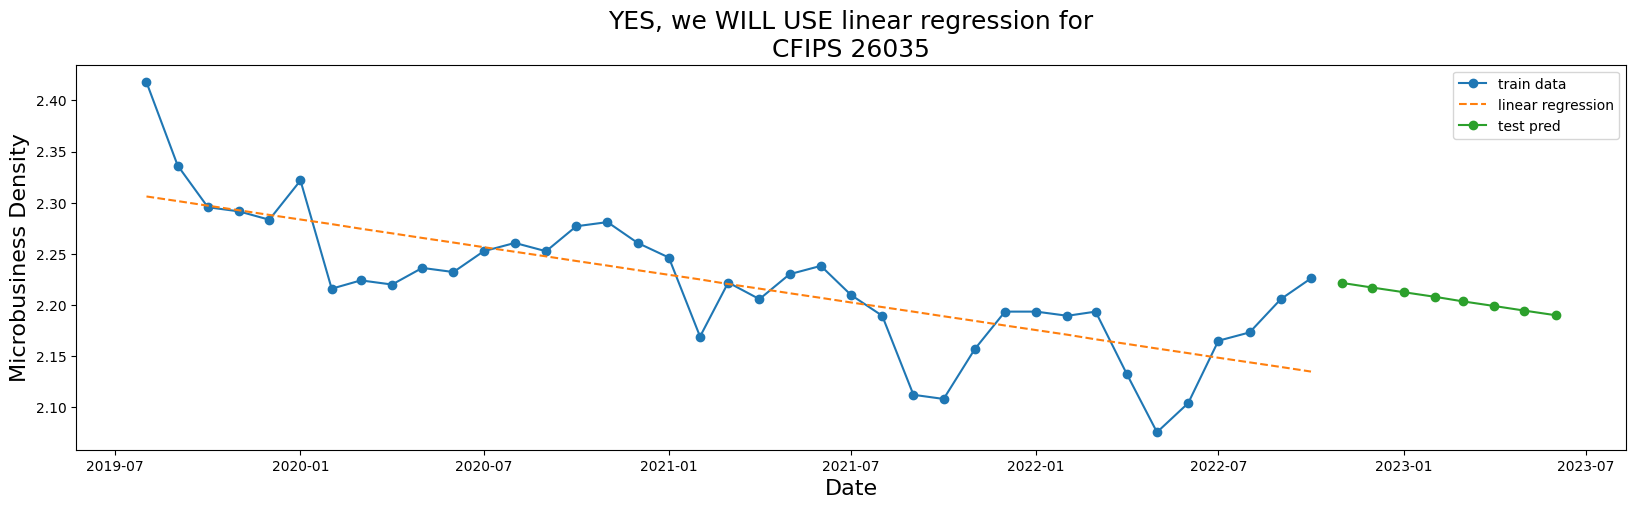

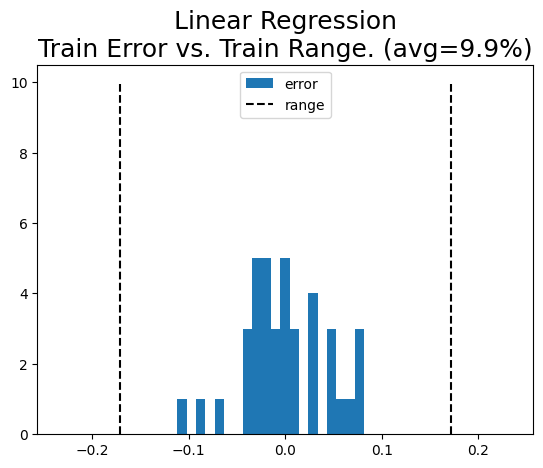

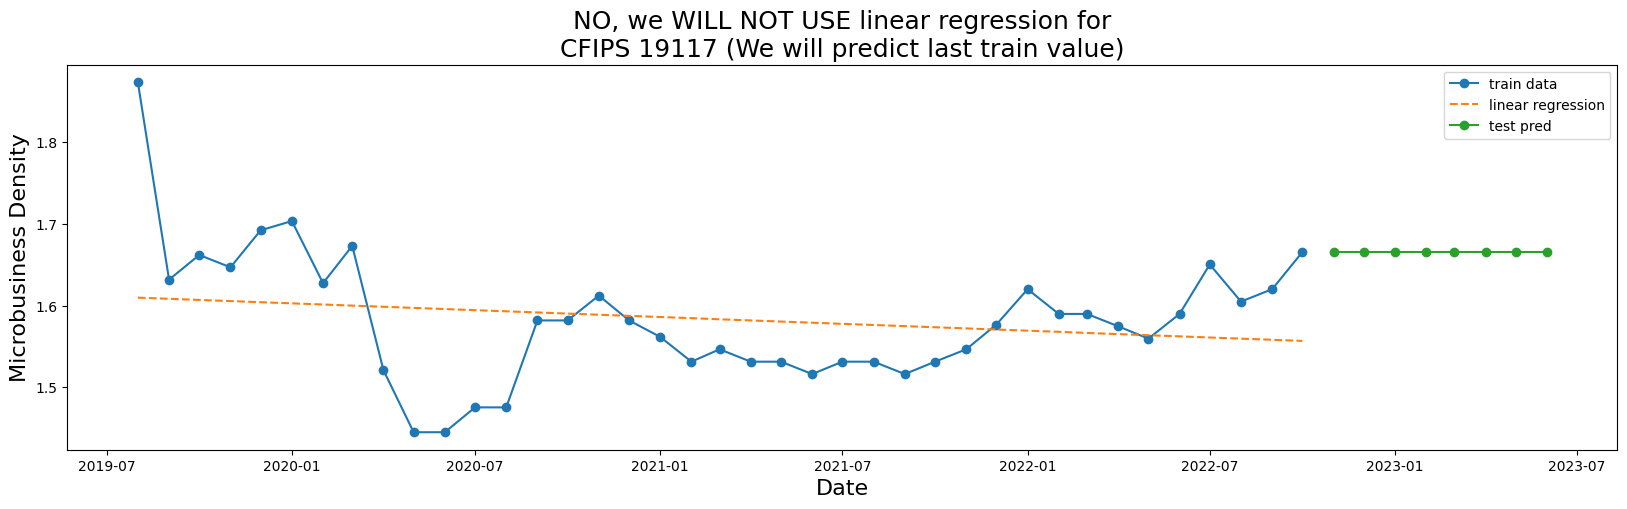

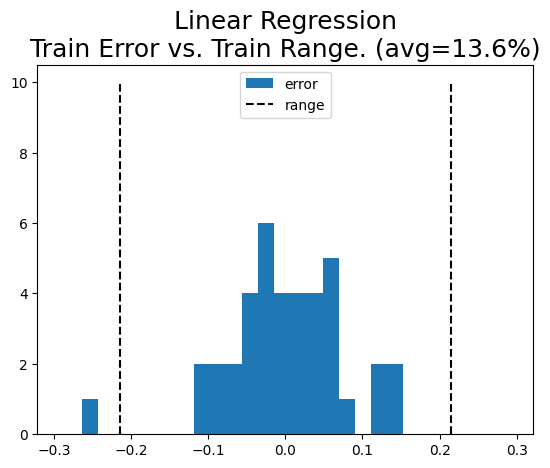

In [8]:
DISPLAY = 8
THRESHOLD = 0.103 #this is 10.3% same value as 8/78 from old notebook

IDS = train.cfips.unique()
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(38,47).reshape((-1,1))

for i in range(DISPLAY):
    c = np.random.choice(IDS)
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    
    # FIT LINEAR REGRESSION
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density)
    p = model.predict(x_train)
    
    # COMPUTE TRAIN ERROR
    err = p - df.microbusiness_density.values
    rng = df.microbusiness_density.max() - df.microbusiness_density.min()
    
    # DETERMINE IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(39):
        e = np.abs( err[k] )
        r = e/rng # absolute error divided by range
        s += r
    s = s/39 # now S is MAPE mean absolute percentage error
        
    # INFER TEST DATA WITH LINEAR REGRESSION
    p2 = model.predict(x_test)
    shift =  last - p2[0]
    if s<THRESHOLD: preds = p2[1:]+shift
    else: preds = [last]*8
     
    # PLOT STUFF
    plt.figure(figsize=(20,5))
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label='train data')
    plt.plot(df.first_day_of_month,p,'--',label='linear regression')
    plt.plot(test.first_day_of_month.values[:8],preds,'-o',label='test pred')
    pre = ''; post=''
    if s>THRESHOLD: 
        pre='NO, we WILL NOT USE linear regression for\n'
        post=' (We will predict last train value)'
    else: 
        pre='YES, we WILL USE linear regression for\n'
    plt.title(f'{pre}CFIPS {c}{post}',size=18)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    
    plt.hist(err,bins=20,label='error')
    plt.plot([-rng/2,-rng/2],[0,10],'--',color='black',label='range')
    plt.plot([rng/2,rng/2],[0,10],'--',color='black')
    plt.xlim((-rng * 0.75,rng * 0.75))
    plt.legend()
    plt.title(f'Linear Regression\nTrain Error vs. Train Range. (avg={100*s:2.1f}%)',size=18)
    plt.show()
    print('\n\n\n\n\n\n')

# Train and Infer Linear Regression
For each of 3135 time series, we model with linear regression and compute the error of train data vs. predicted train data. If the average error is less than 10% of the range of train values, we assume the time series has a linear trend. For these 486 counties we use linear regression to predict test. For the other 2649, we use the last known value in train and the test prediction.

UPDATE in version 9: As an experiment, we will only assume linear trend only if county has more than 25,000 `active`. The train data column `active` indicates the size of the population in county. I think a trend involving more people should be more likely to continue to occur. With this additional restriction, we will use linear model for 32 counties and "last value" for 3103 counties. Let's see what LB it achieves...

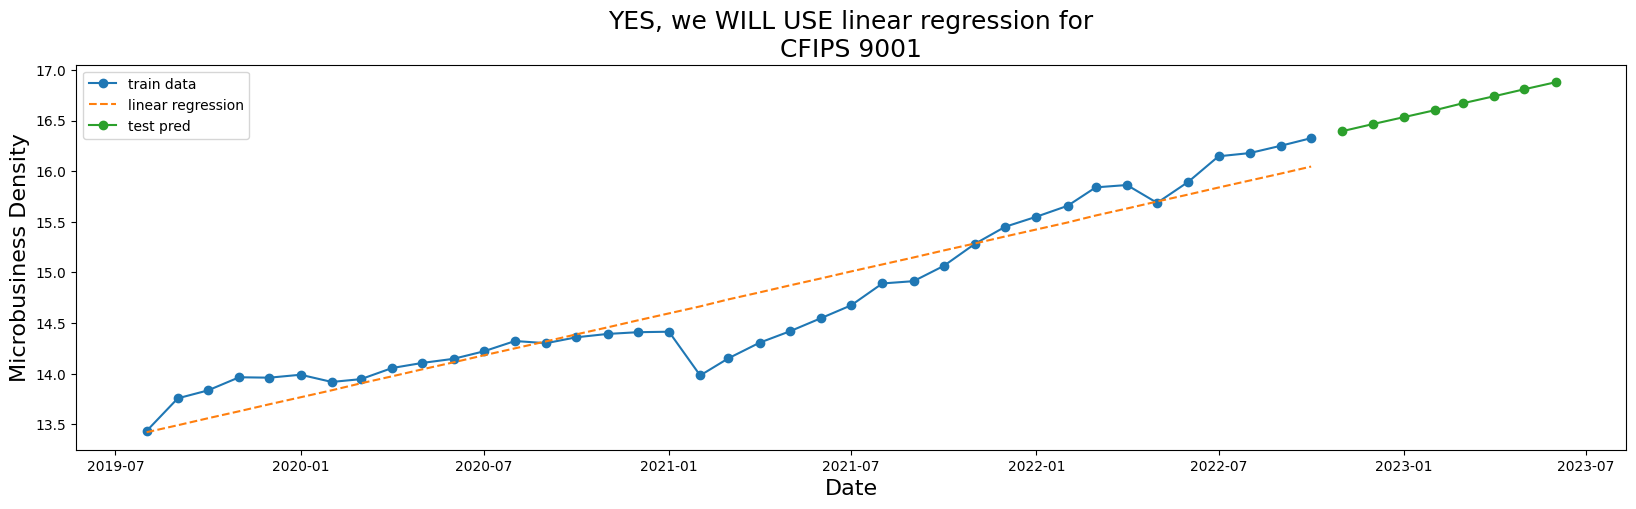

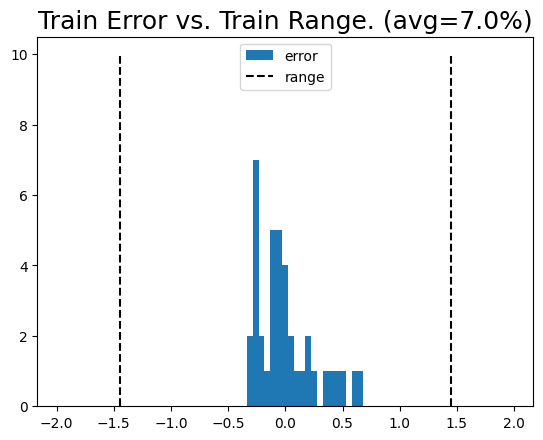

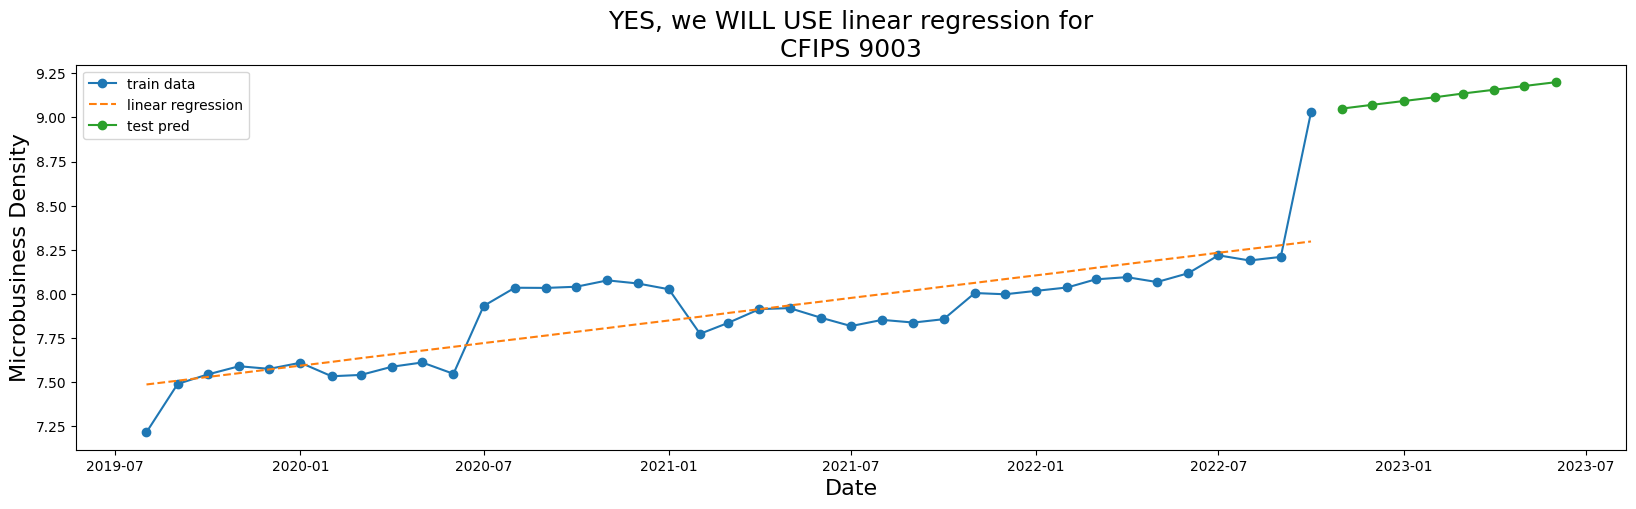

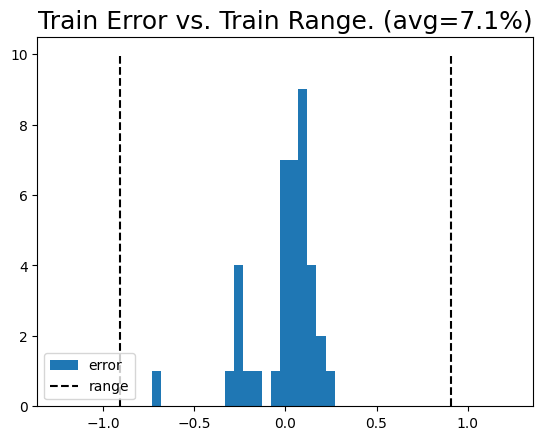

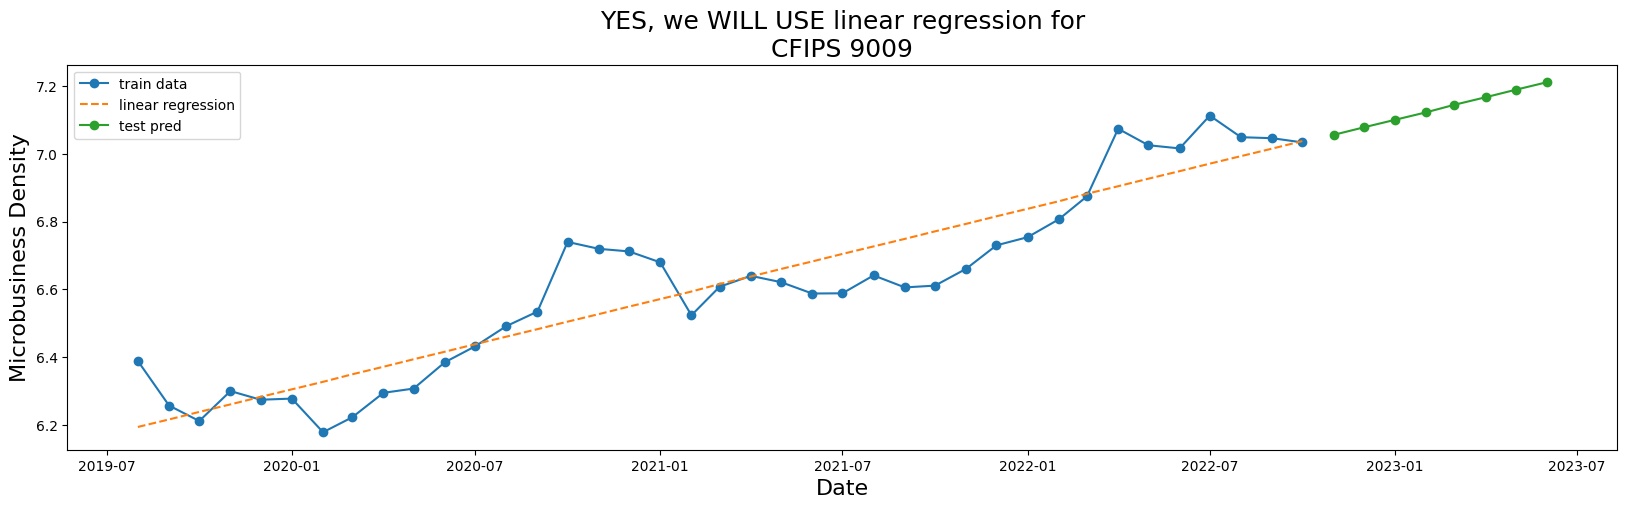

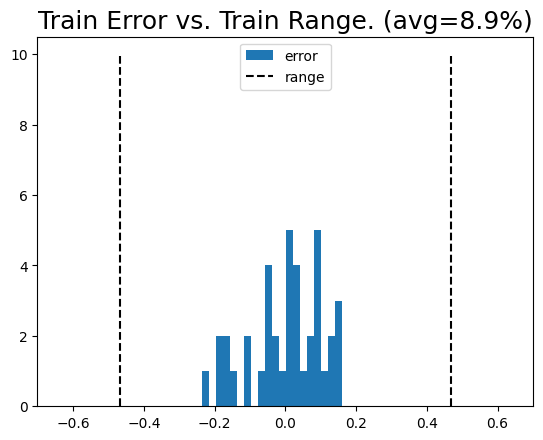

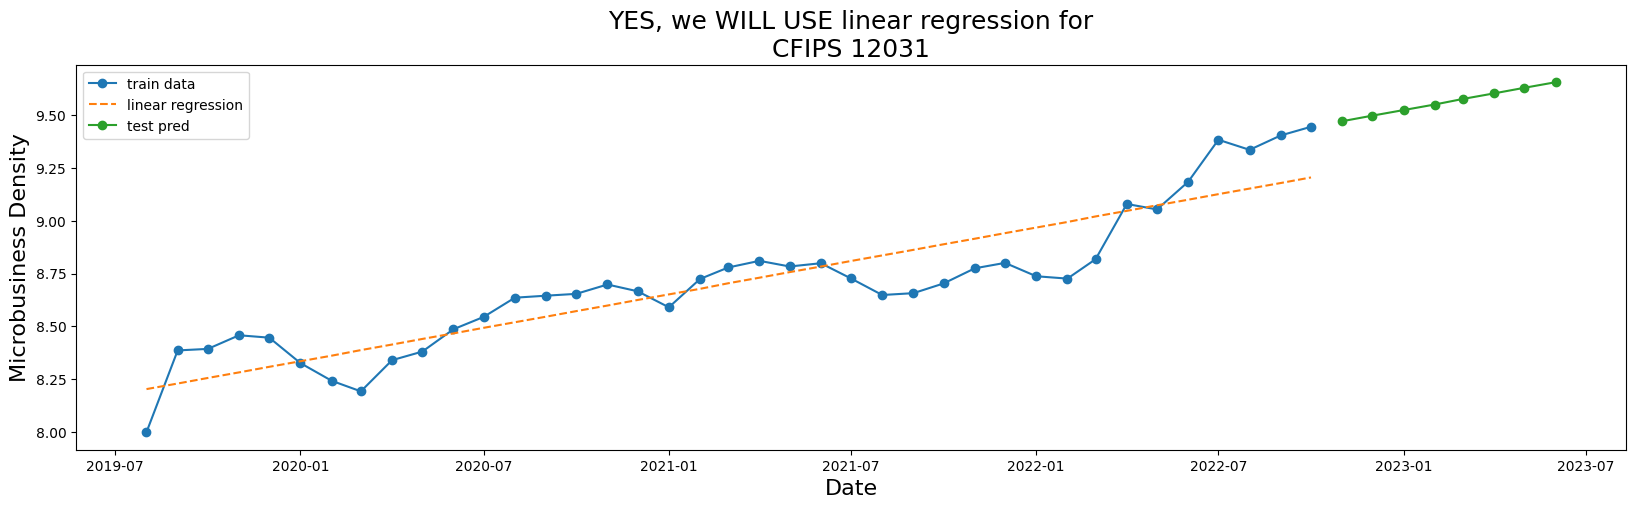

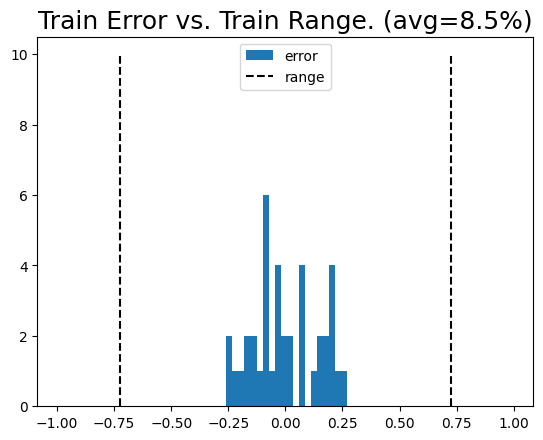

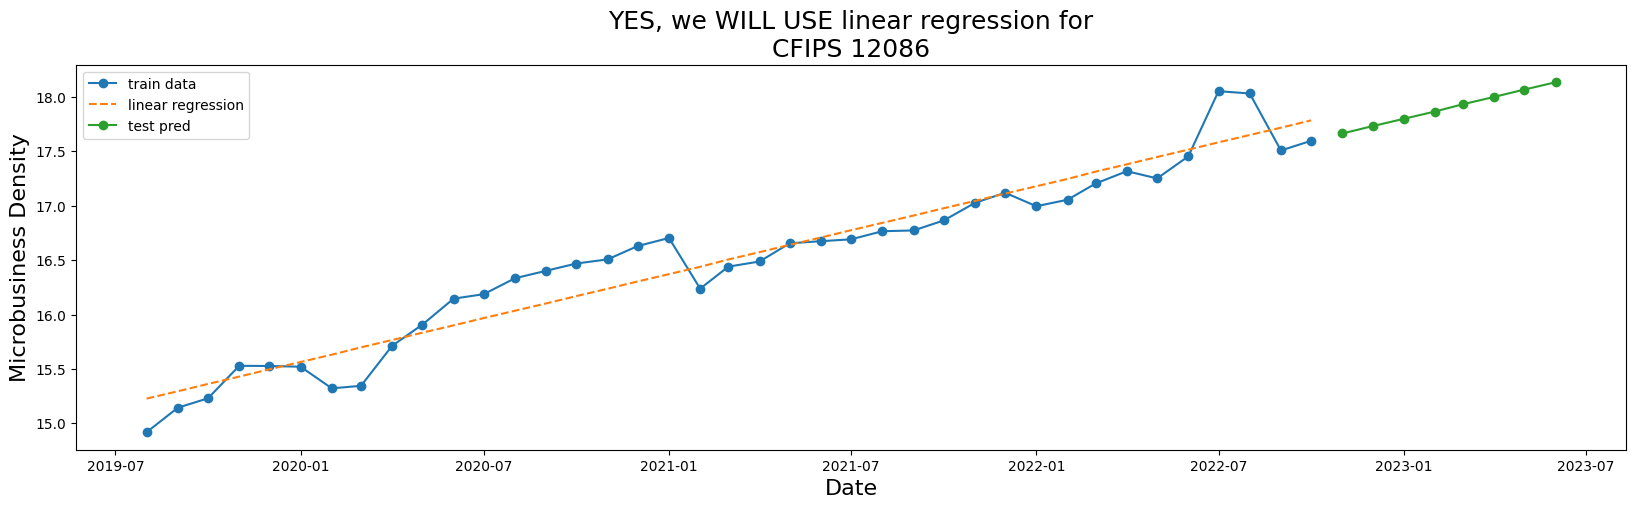

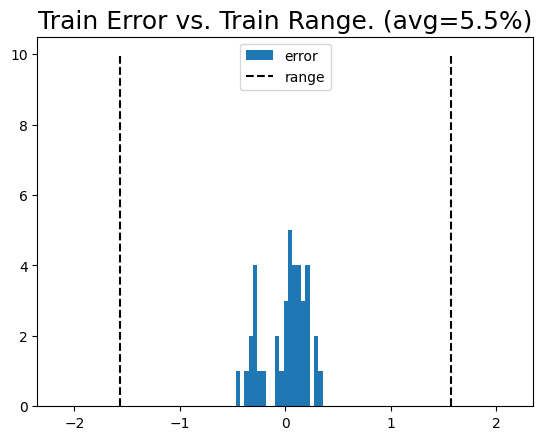

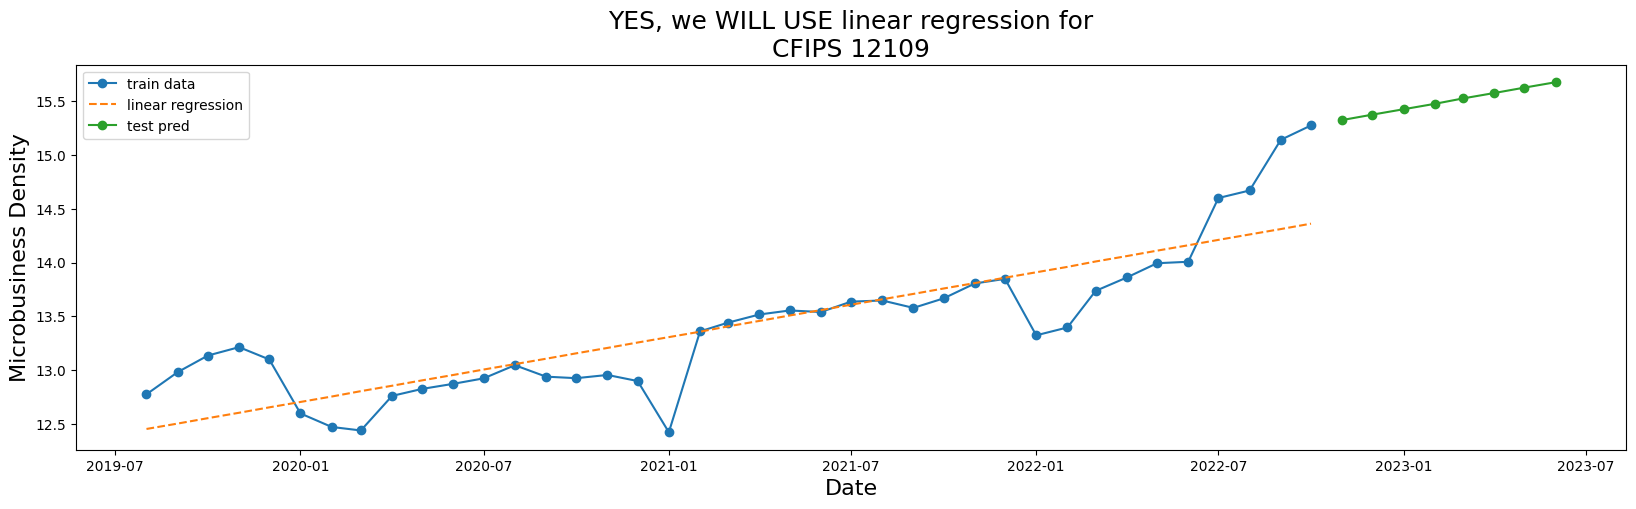

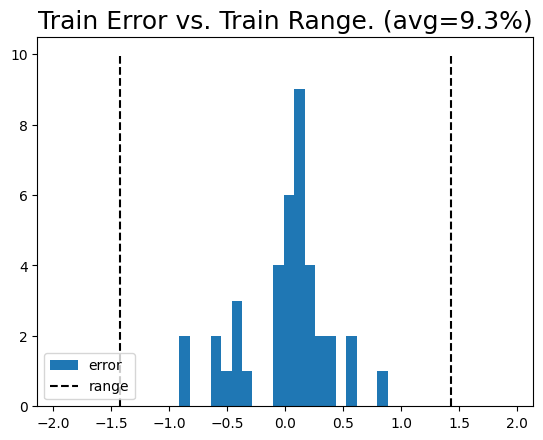

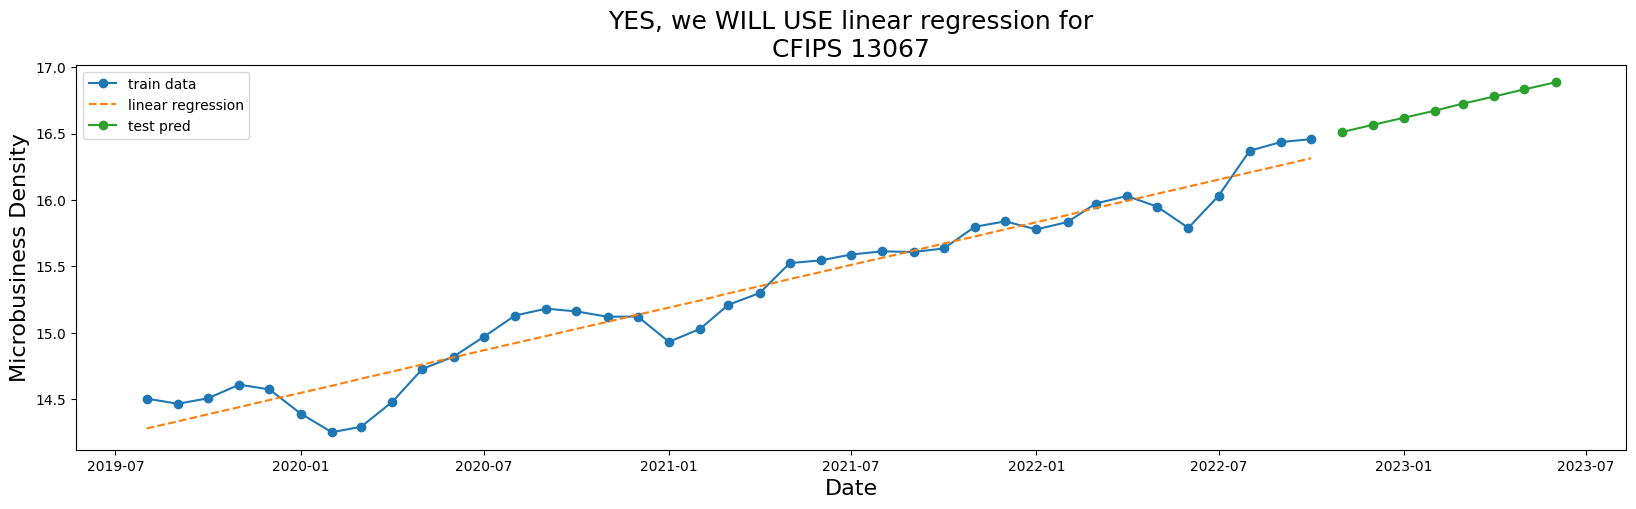

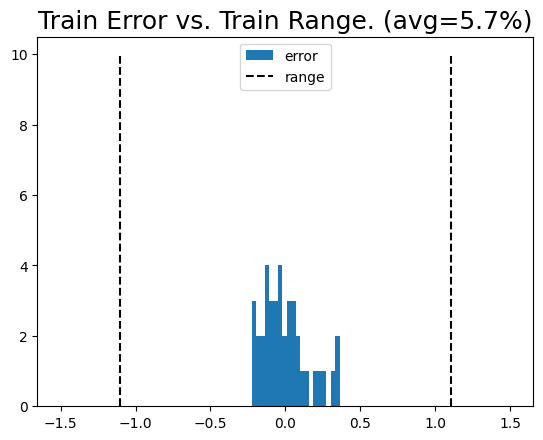

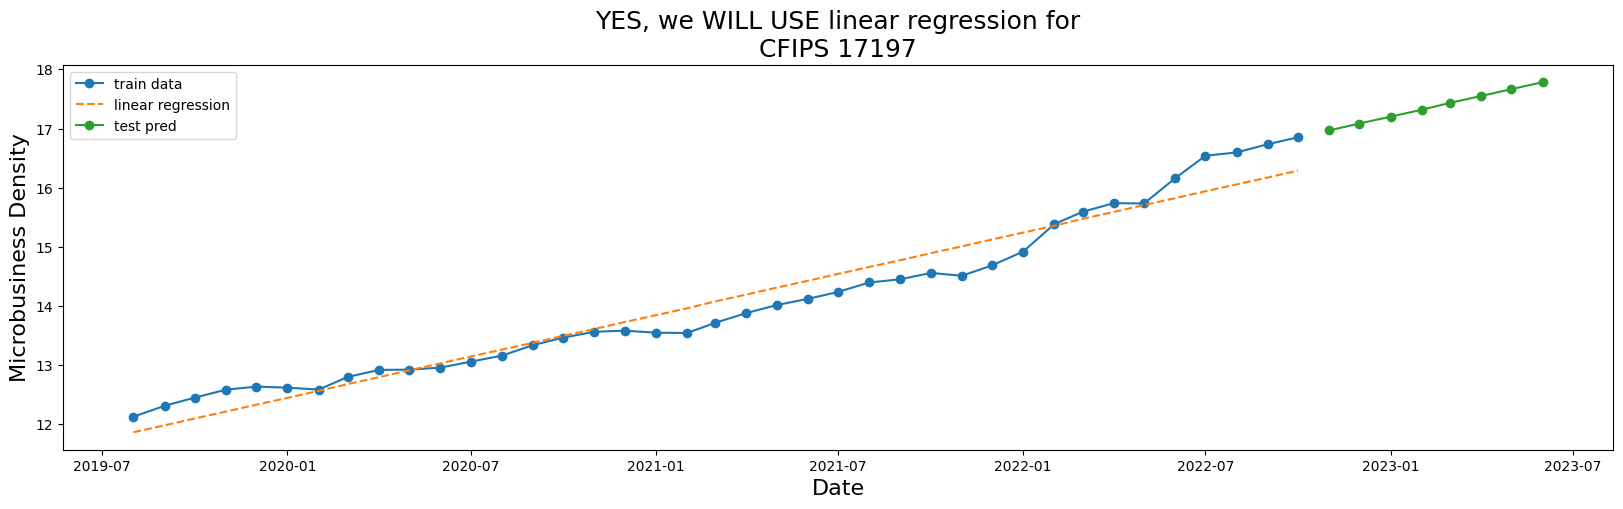

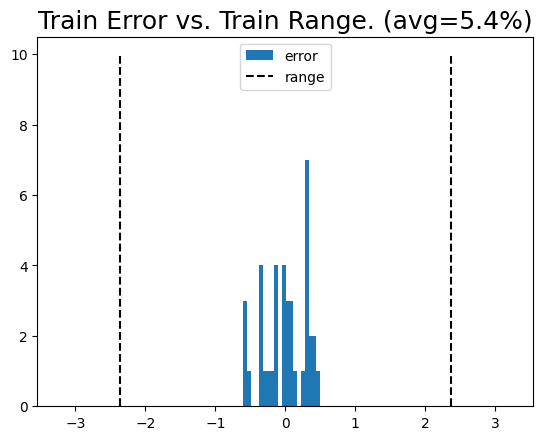








There are 32 counties with both a linear trend and large population.


In [9]:
DISPLAY = 8
THRESHOLD = 0.103 #this is 10.3% same value as 8/78 from old notebook
ACTIVE_THRESHOLD = 25_000

IDS = train.cfips.unique()
x_train = np.arange(39).reshape((-1,1))
x_test = np.arange(38,47).reshape((-1,1))

preds = np.zeros((len(IDS),8))
last_preds = np.zeros((len(IDS),8))
lin_trend = 0

ct = 0
for i,c in enumerate(IDS):
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    active = df.active.values[-1]
    last_preds[i,] = [last]*8
    
    # FIT LINEAR REGRESSION
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density)
    p = model.predict(x_train)
    
    # COMPUTE TRAIN ERROR
    err = p - df.microbusiness_density.values
    rng = df.microbusiness_density.max() - df.microbusiness_density.min()
    
    # DETERMIN IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(39):
        e = np.abs( err[k] )
        r = e/rng # absolute error divided by range
        s += r
    s = s/39 # now S is MAPE mean absolute percentage error
    
    # IF S <= 10% THEN WE ASSUME THIS COUNTY HAS A LINEAR TREND
    if (s>THRESHOLD)|(active<ACTIVE_THRESHOLD): 
        preds[i,] = [last]*8
        continue
        
    # INFER TEST DATA WITH LINEAR REGRESSION
    p2 = model.predict(x_test)
    shift =  last - p2[0]
    preds[i,] = p2[1:]+shift
    
    # COUNT STUFF
    ct += 1
    lin_trend += 1
    if ct>=DISPLAY+1: continue
        
    # PLOT STUFF
    plt.figure(figsize=(20,5))
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label='train data')
    plt.plot(df.first_day_of_month,p,'--',label='linear regression')
    plt.plot(test.first_day_of_month.values[:8],preds[i,],'-o',label='test pred')
    pre='YES, we WILL USE linear regression for\n'
    plt.title(f'{pre}CFIPS {c}',size=18)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    
    plt.hist(err,bins=20,label='error')
    plt.plot([-rng/2,-rng/2],[0,10],'--',color='black',label='range')
    plt.plot([rng/2,rng/2],[0,10],'--',color='black')
    plt.xlim((-rng * 0.75,rng * 0.75))
    plt.legend()
    plt.title(f'Train Error vs. Train Range. (avg={100*s:2.1f}%)',size=18)
    plt.show()
    print('\n\n\n\n\n\n')
    
# PRINT HOW MANY LINEAR TIME SERIES WE FOUND
print(f'There are {lin_trend} counties with both a linear trend and large population.')

# Write Submission CSV

In [10]:
# NOTE TEST IS SORTED BY CFIPS AND DATA. ADD PREDS TO DATAFRAME
test['microbusiness_density'] = preds.reshape((-1))
sub = test[['row_id','microbusiness_density']]
sub.to_csv('submission.csv',index=False)
print( sub.shape )
sub.head()

(25080, 2)


,row_id,microbusiness_density
0,1001_2022-11-01,3.463856
1,1001_2022-12-01,3.463856
2,1001_2023-01-01,3.463856
3,1001_2023-02-01,3.463856
4,1001_2023-03-01,3.463856
